# Manual operations

Subsections should be self-contained

## Manual filter of datasets

In [ ]:
from pinn.io import load_ds, write_tfrecord
def filter_ef(datum):
    import tensorflow as tf
    return (datum['e_data']<-2944.) and (tf.reduce_max(tf.abs(datum['f_data']))<0.2)
ds = load_ds('../pils-v3.yml').filter(filter_ef)

## Generation of geometry from experiments

In [3]:
from ase.io import read, write
from glob import glob
import os
for comp in ['a0b0i32', 'a32b32i0', 'a16b16i16']:
    for rho in ['1.16', '1.08']:
        geo = read(f'../exp/prod-adam-run2/prod/gen30/nvt-340k-5ns-0/{comp}-r{rho}/asemd.traj', index='-1')
        write(f'../skel/init/prod-geo/{comp}-r{rho}.xyz', geo)
        # os.mkdir(f'dummy/{comp}-r{rho}/')
        # write(f'dummy/{comp}-r{rho}/asemd.traj', [geo])

## Checking the unwrapping of Trajs for MSD

In [ ]:
import numpy as np
from glob import glob
from tips.io import load_ds
from ase.data import atomic_masses as am
from lib.transport import rmcom, mktopo, cktopo


def load_chunk(
        dataset, fmt, emap, # load_opts
        stride, t_start, t_end, t_check, dt,
):
    from ase.data import atomic_masses as am
    stride = round(stride/dt)
    start  = round(t_start/dt)
    end    = round(t_end/dt if t_end else -1)
    
    if len(dataset)==1 and dataset[0].endswith('.traj'):
        ds = load_ds(dataset[0], fmt='asetraj', index=f'{start}:{end}:{stride}')
    else:
        ds = load_ds(f'{dataset[0]}/cp2k-md', fmt='cp2k')
        for restart in dataset[1:]:
            ds = ds.join(load_ds(f'{restart}/cp2k-md', fmt='cp2k')[1:])
        ds = ds[start:end:stride]
    return ds
testgeo = 'a0b0i32-rho1.0753'
trajs = sorted(glob(f'../trajs/cp2k/nvt-*ps/*{testgeo}'), key=lambda x: int(x.split('-')[1]))
ds = load_chunk(trajs[:], 'cp2k', None, 0.01, 0, None, 1.0, 0.0005)

In [124]:
def rmcom(old_pos, new_pos, cell, masses):
    if old_pos is None:
        return new_pos
    else:
        new_pos = new_pos - np.rint((new_pos-old_pos)/cell)*cell
        return new_pos
    
t_check = 1.0
dt = 0.0005
check  = round(t_check/dt)
masses = np.array([am[i] for i in ds[0]['elem']])
prev_topo, prev_pos = None, None
com_pos = []
log_pos = []
for i, datum in enumerate(ds[::10]):
    print(f'\r {i}:   ', end='')
    if i%check == 0:
        this_topo = mktopo(datum, level=0)
        prev_topo = cktopo(this_topo, prev_topo)
        h_act, o_act, n_act = this_topo
    cell = np.diag(datum['cell'])[None,:]
    prev_pos = rmcom(prev_pos, datum['coord'], cell, masses)
    com_pos.append(np.average(prev_pos, weights=masses, axis=0))
    log_pos.append(prev_pos-np.average(prev_pos, weights=masses, axis=0))
com_pos = np.array(com_pos)
log_pos = np.array(log_pos)

 1099:   

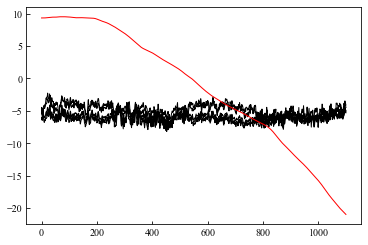

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(log_pos[:,:5,0], lw=1, color='k');
plt.plot(com_pos[:,0], lw=1, color='r');

## Writing out trajectories for visualization

In [80]:
def smart_wrap(atoms):
      #!/usr/bin/env python
    import numpy as np
    from ase import Atoms, neighborlist
    from ase.io import write
    from scipy import sparse
    natoms =  len(atoms)
    
    assert (atoms.cell.angles() == 90.).all(), "Only orthogonal cells allowed."
    cell = atoms.cell.diagonal()
    atoms.wrap()
  
    cutoff = {
        ("H", "C"): 1.74,
        ("H", "N"): 1.9,
        ("H", "O"): 1.9,
        ("C", "C"): 2,
        ("C", "N"): 2,
        ("C", "O"): 2,
    }

    nl_i, nl_j, nl_d = neighborlist.neighbor_list("ijd", atoms, cutoff, self_interaction=False)
    conMat = sparse.dok_matrix((natoms, natoms), dtype=np.int8)
    conMat[nl_i, nl_j] = 1  # we have several running indices here prefixed by (nl, mol, h)
    conMat[nl_j, nl_i] = 1  # v---- shamelessly taken from the ase documentation
    n_mol, mol_assign = sparse.csgraph.connected_components(conMat)
    for mol_i in range(n_mol):
        pos_mol = atoms.positions[mol_assign==mol_i]
        mass_mol = atoms.get_masses()[mol_assign==mol_i]
        pos_mol -= np.rint((pos_mol-pos_mol[:1,:])/cell[None,:])*cell[None,:]
        com_mol = mass_mol@pos_mol/(mass_mol.sum())
        pos_mol -= np.rint(com_mol/cell[None,:]-0.5)*cell[None,:]
        atoms.positions[mol_assign==mol_i] = pos_mol
        
def unwrap(atoms_prev, atoms_next):
    cell = atoms_next.cell.diagonal()
    atoms_next.positions -= np.rint((atoms_next.positions-atoms_prev.positions)
                                    /cell[None,:])*cell[None,:]    
    
    
from tips.io import load_ds
from ase.io import write
import numpy as np
traj_ase = # ..

for idx, (atoms, atoms_ref) in enumerate(zip(traj_ase, [traj_ref[s] for s in sort])):
    if 'stress' in atoms.calc.results : del atoms.calc.results['stress']    
    atoms.calc.results['forces'] -= atoms_ref.calc.results['forces']
    if  idx%100==0:
        print(f'\r{idx} ', end='')
        smart_wrap(atoms)
    else:
        unwrap(traj_ase[idx-1], traj_ase[idx])
write('tmp.xyz', traj_ase[:idx+1])

In [81]:
from tips.io import load_ds
from ase.io import write
import numpy as np
flag = 'gen34/m32i0-r1.08'
# traj = load_ds('../exp/transfer/emd/gen34/m32i0-r1.08/asemd.traj',fmt='asetraj', index='::16')
traj_ref = load_ds(f'../exp/transfer/merge/{flag}/merged.traj',fmt='asetraj', index=':').convert(fmt='ase')
traj_idx = np.loadtxt(f'../exp/transfer/merge/{flag}/merged.idx')
sort = np.argsort(traj_idx)
traj = load_ds(f'../exp/transfer/emd/{flag}/asemd.traj',fmt='asetraj', index=f'0::{int(traj_idx[sort][1])}')
traj_ase = traj.convert(fmt='ase')

for idx, (atoms, atoms_ref) in enumerate(zip(traj_ase, [traj_ref[s] for s in sort])):
    if 'stress' in atoms.calc.results : del atoms.calc.results['stress']    
    atoms.calc.results['forces'] -= atoms_ref.calc.results['forces']
    if  True:#idx%1==0:
        print(f'\r{idx} ', end='')
        smart_wrap(atoms)
    else:
        unwrap(traj_ase[idx-1], traj_ase[idx])
write('tmp.xyz', traj_ase[:idx+1])

9 

In [46]:
from tips.io import load_ds
from ase.io import write

traj = load_ds('../exp/transfer/merge/gen34/m16i16-r1.08/merged.traj',fmt='asetraj', index=':')
traj_ase = traj.convert(fmt='ase')
for idx, atoms in enumerate(traj_ase):
    if 'stress' in atoms.calc.results : del atoms.calc.results['stress']    
    if  True:
        print(f'\r{idx}', end='')
        smart_wrap(atoms)
    else:
        unwrap(traj_ase[idx-1], traj_ase[idx])
write('tmp.xyz', traj_ase)

9